This notebook shows how to initialize and use the LatentVAE class.

In [1]:
from src.models.latent_vae import LatentVAE

In [2]:
# Model configuration
ddconfig = {
    "double_z": True,           # Use double z for VAE
    "z_channels": 8,            # Channels in the bottleneck
    "resolution": 32,           # Input resolution (for latents)
    "in_channels": 16,          # Input channels (for latents)
    "out_ch": 16,               # Output channels
    "ch": 64,                   # Base channel count
    "ch_mult": [1, 2, 2, 2],    # Channel multiplier for each resolution
    "num_res_blocks": 2,        # ResNet blocks per resolution
    "attn_resolutions": [],     # Resolutions at which to apply attention
    "dropout": 0.0,             # Dropout rate
    "attn_type": "none"         # Type of attention ("vanilla", "linear", or "none")
}

# Loss configuration
lossconfig = {
    "target": "src.models.modules.losses.SimpleVAELoss",
    "params": {
        "beta": 0.01,        # Weight for the KL divergence term
    }
}

# Other configuration
embed_dim = 128
ckpt_path = None

# init the LatentVAE model
model = LatentVAE(
    ddconfig=ddconfig,
    lossconfig=lossconfig,
    embed_dim=embed_dim,
    ckpt_path=ckpt_path
)

model

making attention of type 'none' with 128 in_channels
Working with z of shape (1, 8, 4, 4) = 128 dimensions.
making attention of type 'none' with 128 in_channels


LatentVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNor

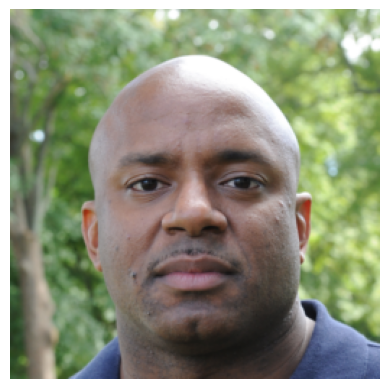

Image shape: torch.Size([1, 3, 256, 256])


In [3]:
# Load one example image
import torch
IMAGE_TENSOR_PATH = "../data/ffhq/pt_images/54321.pt"

img_tensor = torch.load(IMAGE_TENSOR_PATH)

# Add batch dimension: Change from (C, H, W) to (B, C, H, W)
img_tensor = img_tensor.unsqueeze(0)

# Show the image
import matplotlib.pyplot as plt
import numpy as np
img = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((img + 1) / 2)
plt.axis('off')
plt.show()
print("Image shape:", img_tensor.shape)

In [4]:
# Load Stable Diffusion VAE model
from diffusers import AutoencoderKL

sd_vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="vae")
sd_vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [5]:
# Encode the image using the Stable Diffusion VAE
sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()
sd_latent = sd_latent * sd_vae.config.scaling_factor

print("SD Latent shape:", sd_latent.shape)

SD Latent shape: torch.Size([1, 16, 32, 32])


In [6]:
# Encode the latent using the LatentVAE
latent = model.encode(sd_latent).sample()

print("Latent shape:", latent.shape)

Latent shape: torch.Size([1, 128])


In [7]:
# Decode the latent using the LatentVAE
recon = model.decode(latent)

print("Recon shape:", recon.shape)

Recon shape: torch.Size([1, 16, 32, 32])


In [8]:
# Decode the latent using the Stable Diffusion VAE
sd_recon = sd_vae.decode(recon / sd_vae.config.scaling_factor).sample

print("SD Recon shape:", sd_recon.shape)

SD Recon shape: torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6210438..0.68551016].


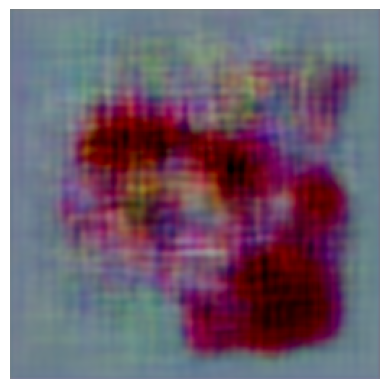

In [9]:
# Show the recon image
recon_img = sd_recon.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow((recon_img + 1) / 2)
plt.axis('off')
plt.show()